True wave speed c_true = 1.0000
Plane wave: kx=6.283, ky=0.000, omega=6.283
Generated 1000 noisy EM field samples.


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch    1 | Total 5.988e+00 | Data 5.987e-01 | PDE 5.981e-04 | c_est ≈ 0.7000
Epoch  500 | Total 3.916e-01 | Data 3.843e-02 | PDE 7.274e-03 | c_est ≈ 0.8175
Epoch 1000 | Total 8.488e-02 | Data 8.027e-03 | PDE 4.617e-03 | c_est ≈ 0.9227
Epoch 1500 | Total 8.232e-02 | Data 3.782e-03 | PDE 4.450e-02 | c_est ≈ 0.9662
Epoch 2000 | Total 2.763e-02 | Data 2.646e-03 | PDE 1.177e-03 | c_est ≈ 0.9846
Epoch 2500 | Total 2.454e-02 | Data 2.420e-03 | PDE 3.413e-04 | c_est ≈ 0.9935
Epoch 3000 | Total 2.434e-02 | Data 2.394e-03 | PDE 4.013e-04 | c_est ≈ 0.9978
Epoch 3500 | Total 2.337e-02 | Data 2.319e-03 | PDE 1.779e-04 | c_est ≈ 1.0000
Epoch 4000 | Total 2.330e-02 | Data 2.302e-03 | PDE 2.779e-04 | c_est ≈ 1.0012
Epoch 4500 | Total 2.311e-02 | Data 2.294e-03 | PDE 1.724e-04 | c_est ≈ 1.0017
Epoch 5000 | Total 2.297e-02 | Data 2.286e-03 | PDE 1.085e-04 | c_est ≈ 1.0022
Epoch 5500 | Total 2.813e-02 | Data 2.788e-03 | PDE 2.527e-04 | c_est ≈ 1.0024
Epoch 6000 | Total 2.307e-02 | Data 2.301e-03 | PDE 

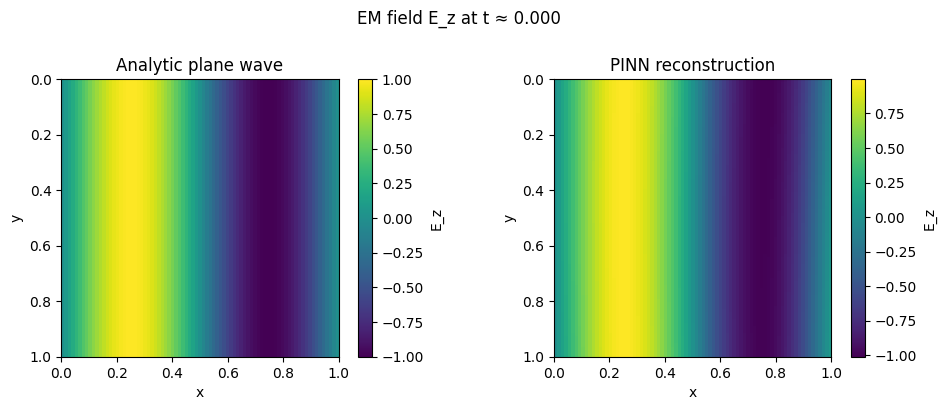

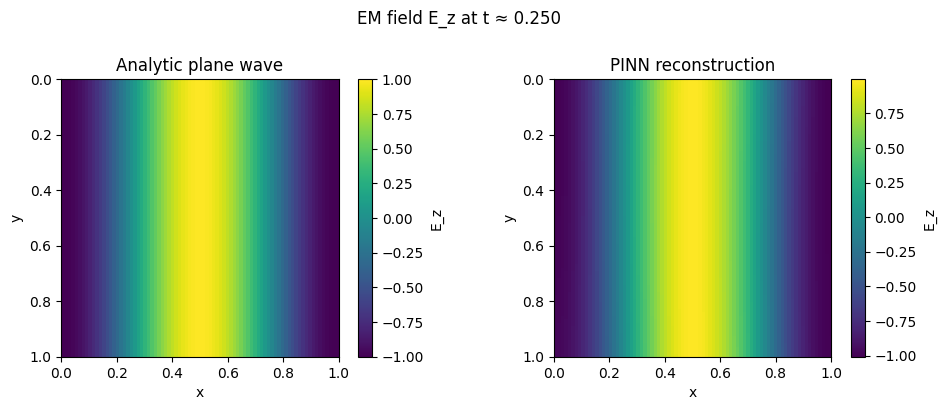

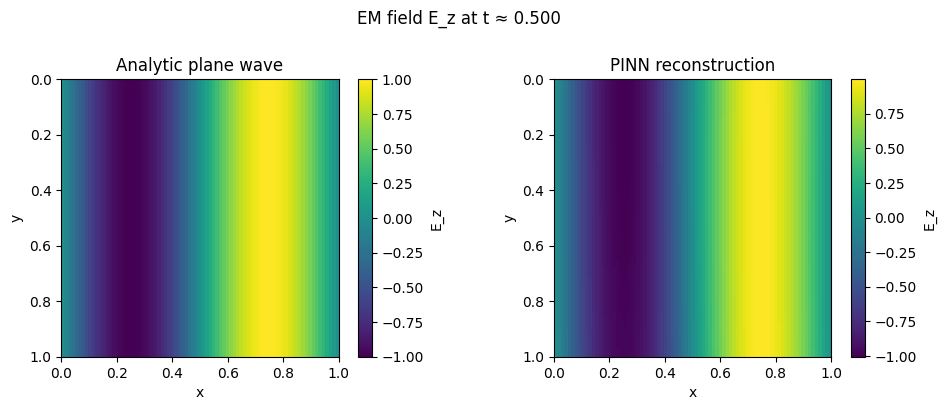

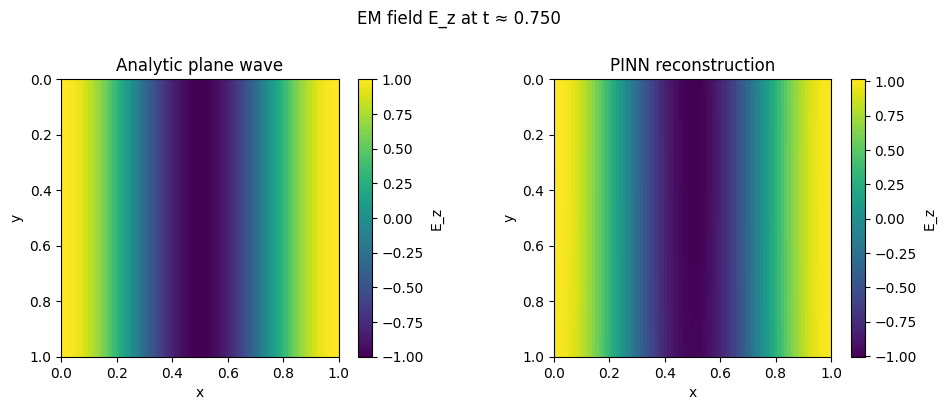

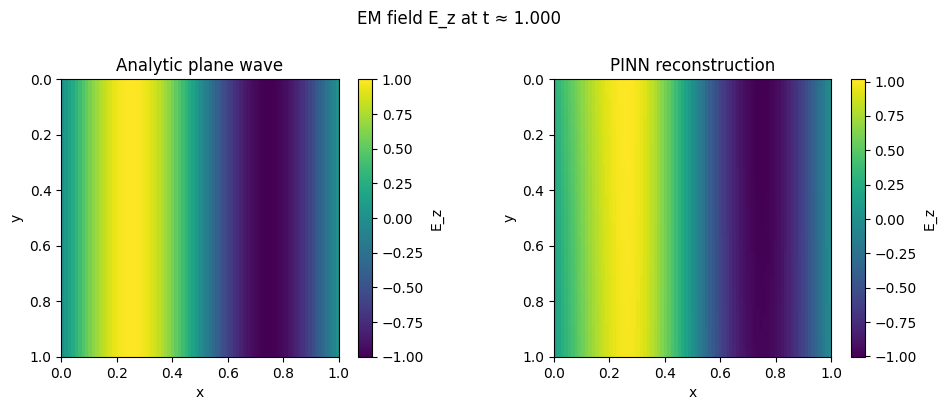

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ============================================================
# 0. General setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# Domain
X_MIN, X_MAX = 0.0, 1.0
Y_MIN, Y_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

# True physics for synthetic data
c_true = 1.0          # wave speed
kx = 2.0 * np.pi      # wave number in x
ky = 0.0              # wave number in y (uniform in y)
omega = c_true * np.sqrt(kx**2 + ky**2)  # 2*pi

print(f"True wave speed c_true = {c_true:.4f}")
print(f"Plane wave: kx={kx:.3f}, ky={ky:.3f}, omega={omega:.3f}")


# ============================================================
# 1. Analytic solution (for synthetic data & validation)
# ============================================================
def analytic_field(x, y, t, c=c_true):
    """
    Plane wave solution of the 2D wave equation:
      E(x,y,t) = sin(kx x + ky y - omega t)
    with dispersion relation omega^2 = c^2 (kx^2 + ky^2).

    We use the same kx, ky as above and omega = c * sqrt(kx^2 + ky^2).
    """
    w = c * np.sqrt(kx**2 + ky**2)
    phase = kx * x + ky * y - w * t
    return np.sin(phase)


# ============================================================
# 2. Generate synthetic noisy data
# ============================================================
N_DATA = 1000
NOISE_STD = 0.05

x_data_np = np.random.uniform(X_MIN, X_MAX, (N_DATA, 1))
y_data_np = np.random.uniform(Y_MIN, Y_MAX, (N_DATA, 1))
t_data_np = np.random.uniform(T_MIN, T_MAX, (N_DATA, 1))

E_clean_np = analytic_field(x_data_np[:, 0], y_data_np[:, 0], t_data_np[:, 0])
E_noisy_np = E_clean_np + NOISE_STD * np.random.randn(N_DATA)

x_data = torch.tensor(x_data_np, dtype=torch.float32, device=DEVICE)
y_data = torch.tensor(y_data_np, dtype=torch.float32, device=DEVICE)
t_data = torch.tensor(t_data_np, dtype=torch.float32, device=DEVICE)
E_data = torch.tensor(E_noisy_np.reshape(-1, 1), dtype=torch.float32, device=DEVICE)

print(f"Generated {N_DATA} noisy EM field samples.")


# ============================================================
# 3. PINN model: E_theta(x,y,t)
# ============================================================
class MLP(nn.Module):
    """
    Simple fully-connected network mapping (x,y,t) -> E(x,y,t).
    """
    def __init__(self, in_dim=3, out_dim=1, width=64, depth=6):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth - 2):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, xyt):
        # xyt: (N,3) with columns [x,y,t]
        return self.net(xyt)


model = MLP().to(DEVICE)

# Wave speed c as a learnable parameter (use log_c to keep c>0)
log_c = nn.Parameter(torch.log(torch.tensor([0.7], device=DEVICE)))  # initial guess
params = list(model.parameters()) + [log_c]


# ============================================================
# 4. Autograd helpers
# ============================================================
def gradients(u, xyt):
    """
    Compute gradients of u wrt [x,y,t].
    u:   (N,1)
    xyt: (N,3) with requires_grad=True
    returns: (N,3) with [du/dx, du/dy, du/dt]
    """
    return torch.autograd.grad(
        outputs=u,
        inputs=xyt,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]


# ============================================================
# 5. Collocation points for PDE
# ============================================================
N_COL = 5000

def sample_interior(n):
    x = np.random.uniform(X_MIN, X_MAX, (n, 1))
    y = np.random.uniform(Y_MIN, Y_MAX, (n, 1))
    t = np.random.uniform(T_MIN, T_MAX, (n, 1))
    xyt = np.hstack([x, y, t])
    xyt = torch.tensor(xyt, dtype=torch.float32,
                       device=DEVICE, requires_grad=True)
    return xyt

xyt_col = sample_interior(N_COL)


# ============================================================
# 6. Loss functions
# ============================================================
def pde_loss(model, xyt_col, c_val):
    """
    Physics loss: wave equation
      E_tt = c^2 (E_xx + E_yy)
    residual r = E_tt - c^2 (E_xx + E_yy).
    """
    # Ensure requires_grad=True
    if not xyt_col.requires_grad:
        xyt_col = xyt_col.clone().detach().requires_grad_(True)

    E = model(xyt_col)                 # (N,1)
    grads = gradients(E, xyt_col)      # (N,3)
    E_x = grads[:, 0:1]
    E_y = grads[:, 1:2]
    E_t = grads[:, 2:3]

    # Second derivatives
    grads_x = gradients(E_x, xyt_col)
    E_xx = grads_x[:, 0:1]

    grads_y = gradients(E_y, xyt_col)
    E_yy = grads_y[:, 1:2]

    grads_t = gradients(E_t, xyt_col)
    E_tt = grads_t[:, 2:3]

    laplace_E = E_xx + E_yy
    residual = E_tt - (c_val**2) * laplace_E
    return torch.mean(residual**2)


def data_loss(model, x_data, y_data, t_data, E_data):
    """
    Data loss: fit noisy measurements.
    """
    xyt = torch.cat([x_data, y_data, t_data], dim=1)
    E_pred = model(xyt)
    return torch.mean((E_pred - E_data)**2)


# ============================================================
# 7. Training loop
# ============================================================
LR = 1e-3
EPOCHS = 6000

W_DATA = 10.0
W_PDE  = 1.0

optimizer = torch.optim.Adam(params, lr=LR)

for epoch in range(1, EPOCHS + 1):
    optimizer.zero_grad()

    c_est = torch.exp(log_c)  # enforce c>0

    l_data = data_loss(model, x_data, y_data, t_data, E_data)
    l_pde  = pde_loss(model, xyt_col, c_est)

    loss = W_DATA * l_data + W_PDE * l_pde
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d} | Total {loss.item():.3e} | "
            f"Data {l_data.item():.3e} | PDE {l_pde.item():.3e} | "
            f"c_est ≈ {c_est.item():.4f}"
        )

c_learned = torch.exp(log_c).item()
print("\nTraining finished.")
print(f"True c = {c_true:.4f}")
print(f"Learned c ≈ {c_learned:.4f}")


# ============================================================
# 8. Evaluate on a grid & visualize snapshots
# ============================================================
def evaluate_on_grid(model, c_val, nx=81, ny=81, nt=5):
    """
    Evaluate PINN on a 3D grid of (x,y,t) and compare with analytic solution.
    """
    x = np.linspace(X_MIN, X_MAX, nx)
    y = np.linspace(Y_MIN, Y_MAX, ny)
    t_slices = np.linspace(T_MIN, T_MAX, nt)

    X, Y = np.meshgrid(x, y)

    E_pred_list = []
    E_true_list = []

    for t_val in t_slices:
        T_grid = t_val * np.ones_like(X)
        xyt_np = np.stack([X.ravel(), Y.ravel(), T_grid.ravel()], axis=1)
        xyt_t = torch.tensor(xyt_np, dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            E_pred = model(xyt_t).cpu().numpy().reshape(ny, nx)
        E_true = analytic_field(X, Y, t_val, c=c_true)

        E_pred_list.append(E_pred)
        E_true_list.append(E_true)

    return x, y, t_slices, E_pred_list, E_true_list

x_grid, y_grid, t_slices, E_pred_list, E_true_list = evaluate_on_grid(model, c_learned)

# Plot a few time slices: PINN vs analytic
for idx, t_val in enumerate(t_slices):
    E_pred = E_pred_list[idx]
    E_true = E_true_list[idx]

    plt.figure(figsize=(10,4))
    plt.suptitle(f"EM field E_z at t ≈ {t_val:.3f}")

    plt.subplot(1,2,1)
    plt.imshow(E_true, extent=[X_MIN, X_MAX, Y_MAX, Y_MIN],
               origin="upper", aspect="equal")
    plt.title("Analytic plane wave")
    plt.colorbar(label="E_z")
    plt.xlabel("x"); plt.ylabel("y")

    plt.subplot(1,2,2)
    plt.imshow(E_pred, extent=[X_MIN, X_MAX, Y_MAX, Y_MIN],
               origin="upper", aspect="equal")
    plt.title("PINN reconstruction")
    plt.colorbar(label="E_z")
    plt.xlabel("x"); plt.ylabel("y")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
